<a href="https://colab.research.google.com/github/captainrotciv4/Disease-Prediction-Toolkit/blob/main/Disease_Prediction_Toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (303, 14)

First 5 rows:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3

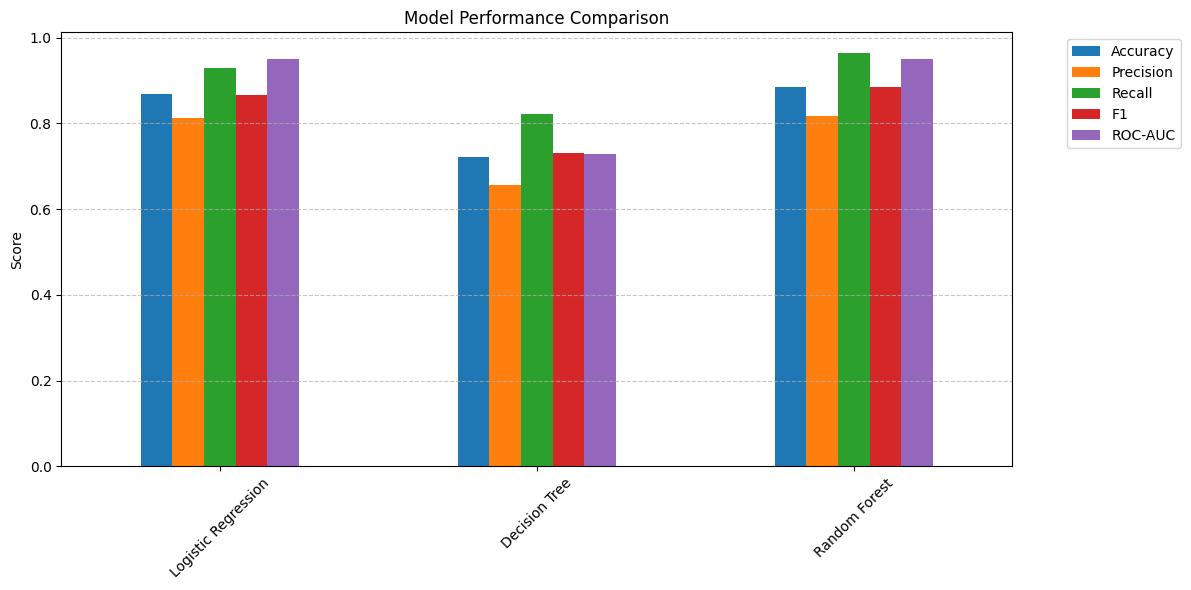

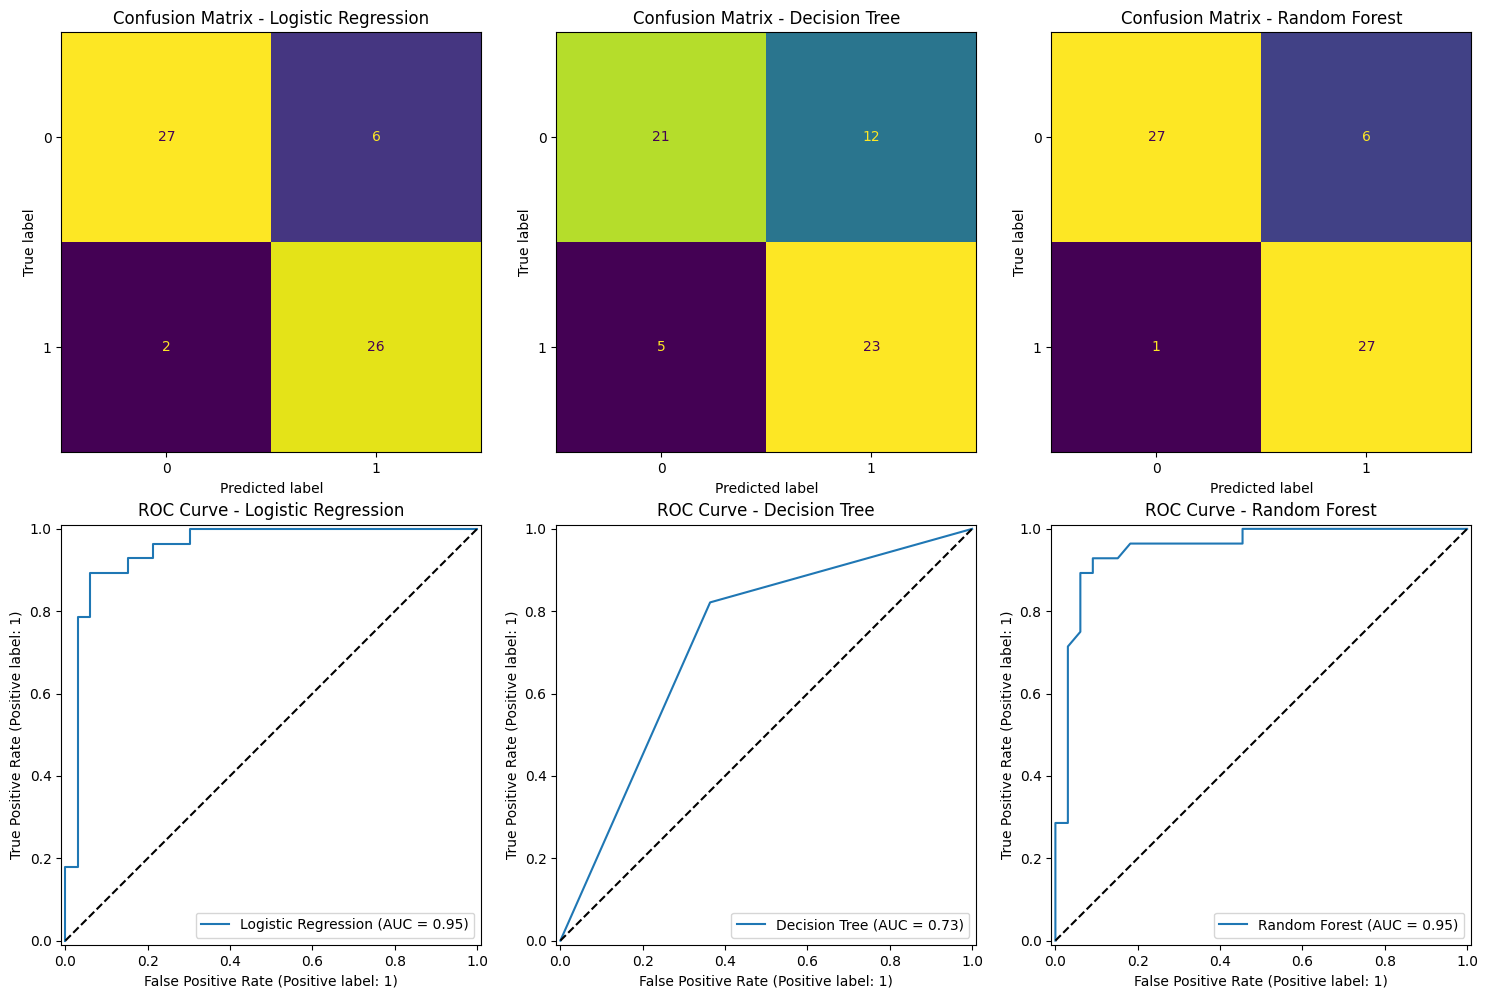

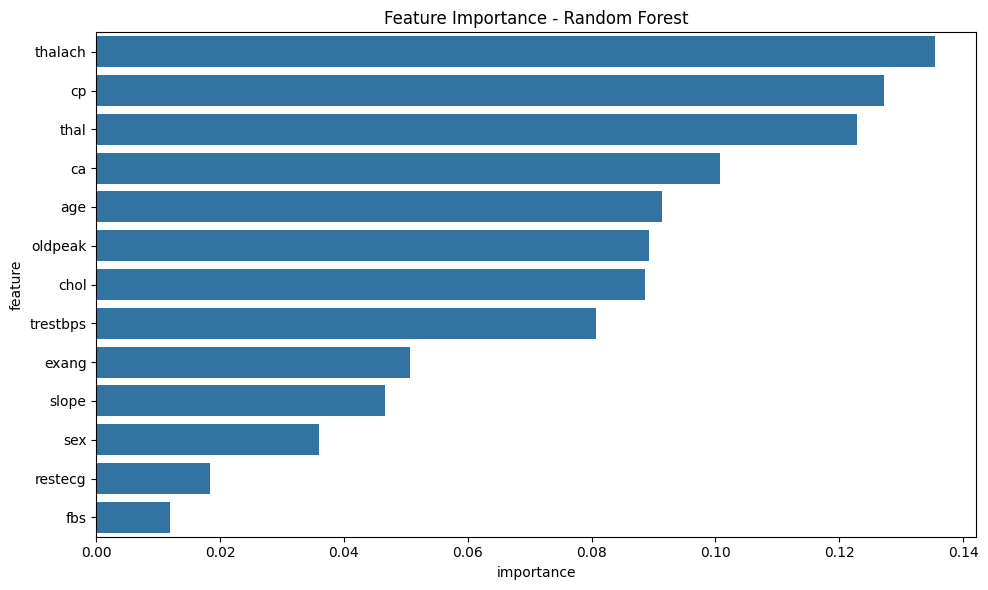


FINAL MODEL SUMMARY

Logistic Regression:
  Accuracy : 0.8689
  Precision: 0.8125
  Recall   : 0.9286
  F1-Score : 0.8667
  ROC-AUC  : 0.9513

Decision Tree:
  Accuracy : 0.7213
  Precision: 0.6571
  Recall   : 0.8214
  F1-Score : 0.7302
  ROC-AUC  : 0.7289

Random Forest:
  Accuracy : 0.8852
  Precision: 0.8182
  Recall   : 0.9643
  F1-Score : 0.8852
  ROC-AUC  : 0.9513

Best model (Random Forest) and scaler saved to disk.


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay)

# Load the dataset
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

# Load the data
df = pd.read_csv('processed.cleveland.data', names=column_names, na_values='?')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Data Preprocessing
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df_imputed = df_imputed.astype(float)  # Convert all to float

# The target in this dataset has values 0-4, but we'll convert to binary (0: no disease, 1: disease)
df_imputed['target'] = df_imputed['target'].apply(lambda x: 0 if x == 0 else 1)

# Separate features and target
X = df_imputed.drop('target', axis=1)
y = df_imputed['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store model performance
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'Model': model,
        'Predictions': y_pred,
        'Probabilities': y_pred_proba
    }

# Create a DataFrame to compare results
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\nModel Performance Comparison:")
print(results_df[['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']].round(4))

# Visualize results
# 1. Model comparison bar plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC']
results_df[metrics].plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Confusion matrices and ROC curves
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (name, res) in enumerate(results.items()):
    # Confusion Matrix
    cm = confusion_matrix(y_test, res['Predictions'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(f'Confusion Matrix - {name}')

    # ROC Curve
    roc_disp = RocCurveDisplay.from_predictions(y_test, res['Probabilities'], ax=axes[i+3], name=name)
    axes[i+3].set_title(f'ROC Curve - {name}')
    axes[i+3].plot([0, 1], [0, 1], 'k--')

plt.tight_layout()
plt.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Feature importance for Random Forest
best_model = results['Random Forest']['Model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final summary
print("\n" + "="*50)
print("FINAL MODEL SUMMARY")
print("="*50)
for name, res in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy : {res['Accuracy']:.4f}")
    print(f"  Precision: {res['Precision']:.4f}")
    print(f"  Recall   : {res['Recall']:.4f}")
    print(f"  F1-Score : {res['F1']:.4f}")
    print(f"  ROC-AUC  : {res['ROC-AUC']:.4f}")

# Save the best model (Random Forest)
import joblib
joblib.dump(best_model, 'heart_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\nBest model (Random Forest) and scaler saved to disk.")

